In [1]:
!nvidia-smi

Tue May 17 04:21:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.01       Driver Version: 516.01       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P8    26W / 350W |    482MiB / 24576MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import torch, torchvision
import torchvision.transforms as transforms
import os, json, PIL
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #GPU 할당

In [30]:
def count(output, target):
    with torch.no_grad():
        predict = torch.argmax(output, 1)
        correct = (predict == target).sum().item()
        return correct

def select_model(model, num_classes):
    if model == 'densenet121':
        model_ = models.densenet121(pretrained=True)
        model_.classifier = nn.Linear(1024, num_classes)
    elif model == 'densenet161':
        model_ = models.densenet161(pretrained=True)
        model_.classifier = nn.Linear(2208, num_classes)
    return model_

class Baseline():
    def __init__(self, model, num_classes, gpu_id=0, epoch_print=1, print_freq=10, save=False):
        self.gpu = gpu_id
        self.epoch_print = epoch_print
        self.print_freq = print_freq
        self.save = save

        torch.cuda.set_device(self.gpu)

        self.loss_function = nn.CrossEntropyLoss().cuda(self.gpu)

        model = select_model(model, num_classes)
        self.model = model.cuda(self.gpu)

        self.train_losses, self.test_losses = [], []
        self.train_acc, self.test_acc = [], []
        self.best_acc = None
        self.best_loss = None

    def train(self, train_data, test_data, epochs=100, lr=0.1, weight_decay=0.0001):
        self.model.train()
        optimizer = optim.Adam(self.model.parameters(), lr, weight_decay=weight_decay)
        
        for epoch in range(epochs):
            if epoch % self.epoch_print == 0: print('Epoch {} Started...'.format(epoch+1))
            for i, (X, y) in enumerate(train_data):
                X, y = X.cuda(self.gpu), y.cuda(self.gpu)
                output = self.model(X)
                loss = self.loss_function(output, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (epoch % self.epoch_print == 0) and (i % self.print_freq == 0):
                    train_acc = 100 * count(output, y) / y.size(0)
                    test_acc, test_loss = self.test(test_data)
                    
                    if self.save and ((self.best_acc == None) or (self.best_acc < test_acc) or (test_loss < self.best_loss)):
                        torch.save(self.model.state_dict(), '{}_{}.pt'.format(epoch, i))
                        self.best_acc = test_acc
                        self.best_loss = test_loss
                        print('Best Model Saved')

                    self.train_losses.append(loss.item())
                    self.train_acc.append(train_acc)
                    self.test_losses.append(test_loss)
                    self.test_acc.append(test_acc)

                    print('Iteration : {} - Train Loss : {:.6f}, Test Loss : {:.6f}, '
                          'Train Acc : {:.6f}, Test Acc : {:.6f}'.format(i+1, loss.item(), test_loss, train_acc, test_acc))
            print()

    def test(self, test_data):
        correct, total = 0, 0
        losses = []

        self.model.eval()
        with torch.no_grad():
            for i, (X, y) in enumerate(test_data):
                X, y = X.cuda(self.gpu), y.cuda(self.gpu)
                output = self.model(X)

                loss = self.loss_function(output, y)
                losses.append(loss.item())
                
                correct += count(output, y)
                total += y.size(0)
        self.model.train()
        return (100*correct/total, sum(losses)/len(losses))

In [31]:
from glob import glob
import pandas as pd

label_df = pd.read_csv('C:/Users/ideal/Downloads/jupyter/user_data/train.csv')

data_dir = 'C:/Users/ideal/Downloads/jupyter/user_data/train/'
imgs, labels = [], []
for num in sorted(os.listdir(data_dir)):
        imgs.extend(glob(os.path.join(data_dir, '*.png')))
#         imgs.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
        
        labels.extend(label_df['label'])

label_info = {label:i for i, label in enumerate(sorted(set(labels)))}
train_imgs, val_imgs, train_labels, val_labels = train_test_split(imgs, labels, random_state=0, stratify=labels)

class TrainDataset(Dataset):
    def __init__(self, transform=None):
        self.imgs = train_imgs
        self.labels = train_labels
        self.label_info = label_info
        self.transform = transform

    def __getitem__(self, idx):
        img = PIL.Image.open(self.imgs[idx]).convert('RGB')
        if self.transform: img = self.transform(img)

        label = self.label_info[self.labels[idx]]
        return img, label

    def __len__(self):
        return len(self.imgs)
    
class ValDataset(Dataset):
    def __init__(self, transform=None):
        self.imgs = val_imgs
        self.labels = val_labels
        self.label_info = label_info
        self.transform = transform

    def __getitem__(self, idx):
        img = PIL.Image.open(self.imgs[idx]).convert('RGB')
        if self.transform: img = self.transform(img)

        label = self.label_info[self.labels[idx]]
        return img, label

    def __len__(self):
        return len(self.imgs)

In [32]:
label_info

{'1': 0,
 '10-1': 1,
 '10-2': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10}

In [33]:
len(train_imgs)

552123

In [34]:
len(imgs)

736164

In [35]:
len(val_imgs)

184041

In [36]:
labels

['10-2',
 '10-1',
 '3',
 '8',
 '9',
 '9',
 '8',
 '10-2',
 '5',
 '5',
 '9',
 '2',
 '4',
 '10-1',
 '9',
 '2',
 '10-2',
 '7',
 '4',
 '2',
 '6',
 '10-1',
 '10-1',
 '6',
 '10-1',
 '5',
 '6',
 '3',
 '10-2',
 '8',
 '1',
 '2',
 '8',
 '2',
 '5',
 '10-1',
 '6',
 '1',
 '1',
 '4',
 '4',
 '10-2',
 '7',
 '4',
 '4',
 '9',
 '10-2',
 '9',
 '8',
 '2',
 '6',
 '10-1',
 '9',
 '5',
 '3',
 '3',
 '6',
 '2',
 '1',
 '2',
 '10-1',
 '10-2',
 '5',
 '3',
 '4',
 '6',
 '6',
 '7',
 '2',
 '8',
 '6',
 '10-2',
 '9',
 '10-2',
 '6',
 '3',
 '8',
 '10-2',
 '1',
 '7',
 '6',
 '1',
 '6',
 '9',
 '6',
 '7',
 '3',
 '10-1',
 '3',
 '10-1',
 '10-1',
 '4',
 '3',
 '1',
 '6',
 '6',
 '2',
 '6',
 '9',
 '7',
 '9',
 '4',
 '2',
 '7',
 '10-1',
 '4',
 '3',
 '2',
 '6',
 '4',
 '3',
 '10-1',
 '9',
 '2',
 '7',
 '10-2',
 '8',
 '10-1',
 '5',
 '5',
 '6',
 '10-2',
 '9',
 '10-2',
 '7',
 '6',
 '2',
 '10-2',
 '1',
 '5',
 '5',
 '5',
 '4',
 '6',
 '4',
 '9',
 '10-1',
 '6',
 '1',
 '7',
 '2',
 '9',
 '4',
 '3',
 '1',
 '4',
 '3',
 '6',
 '2',
 '10-1',
 '7',
 '10

In [37]:
batch_size = 32

train_transform = transforms.Compose([
    transforms.RandomCrop((224, 224)),
    transforms.ToTensor()])

val_transform = transforms.Compose([
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor()])

In [38]:
train_dataset = TrainDataset(transform=train_transform)
val_dataset = ValDataset(transform=val_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [39]:
model = Baseline(model='densenet121', num_classes=len(train_dataset.label_info), print_freq=5, save=True)

In [40]:
epochs = 10
lr = 0.0005
weight_decay = 0.00001

In [41]:
model.train(train_loader, val_loader, epochs=epochs, lr=lr, weight_decay=weight_decay)

Epoch 1 Started...


KeyboardInterrupt: 

NameError: name 'label_fontsize' is not defined

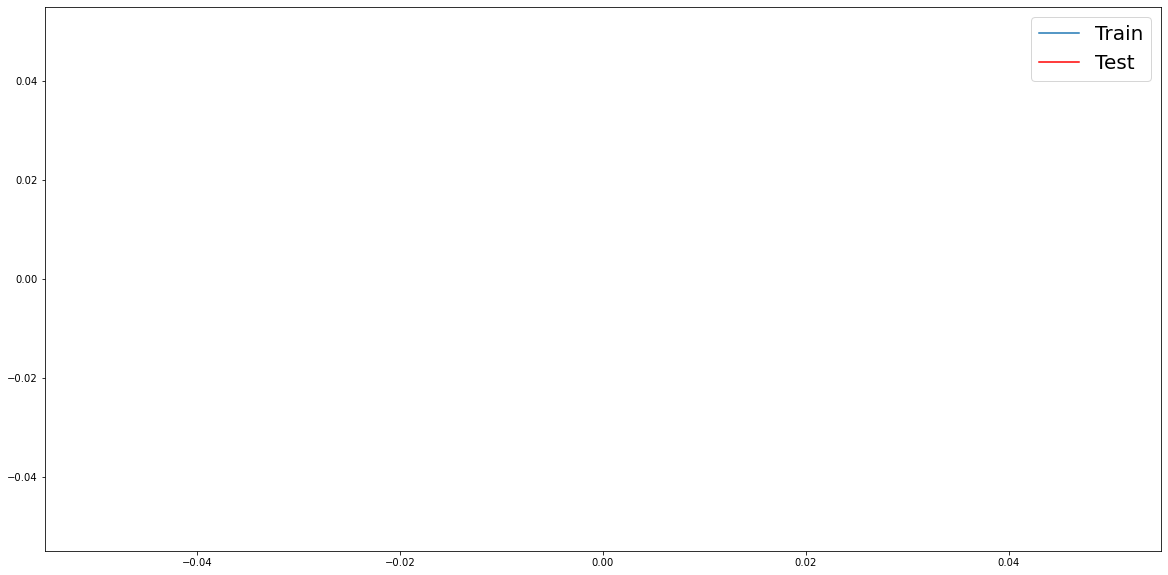

In [12]:
# label_fontsize = 25

plt.figure(figsize=(20, 10))
train_lossline, = plt.plot(model.train_losses, label='Train')
test_lossline, = plt.plot(model.test_losses, color='red', label='Test')
plt.legend(handles=[train_lossline, test_lossline], fontsize=20)
plt.xlabel('Step', fontsize=label_fontsize)
plt.ylabel('Loss', fontsize=label_fontsize)
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
train_accline, = plt.plot(model.train_acc, label='Train')
test_accline, = plt.plot(model.test_acc, color='red', label='Test')
plt.legend(handles=[train_accline, test_accline], fontsize=20)
plt.xlabel('Step', fontsize=label_fontsize)
plt.ylabel('Acc', fontsize=label_fontsize)
plt.show()

In [ ]:
model = Baseline(model='densenet161', num_classes=10)
model.model.load_state_dict(torch.load('./8_225.pt'))
model.model.eval()

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop((224, 224)),
    transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_df = pd.read_csv('/home/hand image/test.csv')
test_data_dir = '/home/hand image/test/'
predictions, test_img = [], []
for num in sorted(os.listdir(test_data_dir)):
        test_img.extend(glob(os.path.join(test_data_dir, '*.png')))
        test_img.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
        predictions.extend(test_df['file_name'])

with torch.no_grad():
    for num in sorted(os.listdir(test_data_dir)):
        imgs = torch.stack(imgs).cuda()
        prediction = torch.nn.Softmax(dim=1)(model.model(imgs))
        prediction = torch.mean(prediction, dim=0)
            
        if torch.sum(prediction) != 1: print(torch.sum(prediction))
        predictions.append(prediction.cpu().numpy())

print(len(predictions))
print(len(predictions[0]))

In [46]:
submission = pd.read_csv('/home/hand image/sample_submission.csv')
submission['label'] = predictions

In [48]:
submission.head()

,file_name,label
0,001.png,1
1,002.png,2
2,003.png,1
3,004.png,6
4,005.png,7


In [49]:
submission.to_csv('submit.csv', index=False)